In [1]:
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2024-02-28 15:05:32--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  74.9MB/s    in 0.7s    

2024-02-28 15:05:33 (74.9 MB/s) - ‘data/PennFudanPed.zip.1’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

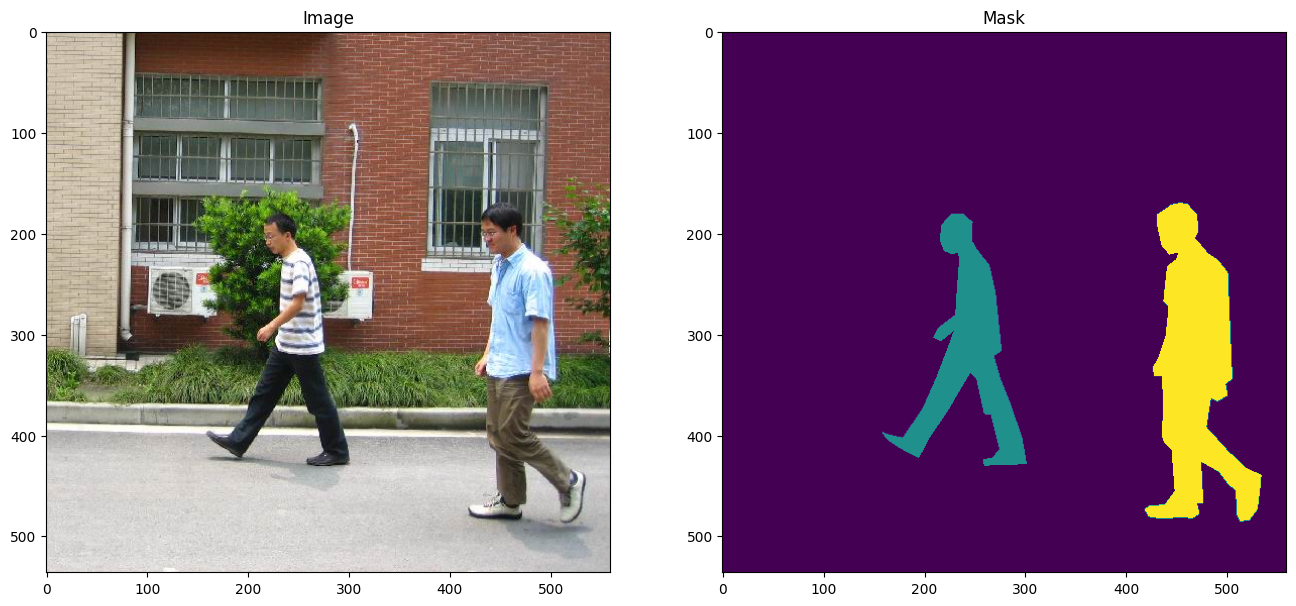

In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image('data/PennFudanPed/PNGImages/FudanPed00001.png')
mask = read_image('data/PennFudanPed/PedMasks/FudanPed00001_mask.png')

plt.figure(figsize = (16,8))
plt.subplot(121)
plt.title('Image')
plt.imshow(image.permute(1,2,0))
plt.subplot(122)
plt.title('Mask')
plt.imshow(mask.permute(1,2,0))

In [4]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py

--2024-02-28 15:07:15--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   8.19K  --.-KB/s    in 0s      

2024-02-28 15:07:15 (66.4 MB/s) - ‘utils.py.1’ saved [8388/8388]

--2024-02-28 15:07:15--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]

In [5]:
!wget wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py

--2024-02-28 15:07:15--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2024-02-28 15:07:15--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8397 (8.2K) [text/plain]
Saving to: ‘coco_utils.py.1’

coco_utils.py.1     100%[===================>]   8.20K  --.-KB/s    in 0s      

2024-02-28 15:07:15 (69.6 MB/s) - ‘coco_utils.py.1’ saved [8397/8397]

FINISHED --2024-02-28 15:07:15--
Total wall clock time: 0.2s
Downloaded: 1 files, 8.2K in 0s (69.6 MB/s)
--2024-02-28 15:07:15--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
Resolving raw.githubusercontent.com (ra

In [6]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

--2024-02-28 15:07:16--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py.1’

transforms.py.1     100%[===================>]  23.07K  --.-KB/s    in 0.002s  

2024-02-28 15:07:16 (9.43 MB/s) - ‘transforms.py.1’ saved [23628/23628]



In [ ]:
import os
import torch

class Dataset(torch.utils.data.Dataset):
  def __init__(self,root,transforms):
    self.root = root
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "PNGImages",self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

    img = read_image(img_path)
    mask = read_image(mask_path)

    obj_ids = torch.unique(mask)

    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)

    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
    boxes = masks_to_boxes(masks)
    labels = torch.ones((num_objs,), dtype=torch.int64)

    image_id = idx
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    img = tv_tensors.Image(img)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format ="XYXY", canvas_size = F.get_size(img))
    target["masks"] = tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [ ]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # Dataset has only two classes namely person and background

dataset_train = Dataset('data/PennFudanPed', get_transform(train = True))
dataset_test = Dataset('data/PennFudanPed', get_transform(train = False))

indices = torch.randperm(len(dataset_train)).tolist()
train_dataset = torch.utils.data.Subset(dataset_train, indices[:-50])
test_dataset = torch.utils.data.Subset(dataset_test, indices[-50:])

In [ ]:
import utils
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 4,
    collate_fn = utils.collate_fn
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 1,
    shuffle = False,
    num_workers = 4,
    collate_fn = utils.collate_fn
)

In [ ]:
learning_rate = 0.00001
momentum = 0.9
batch = 100
no_of_workers = 2
shuffle = True
E = 10 # No of epochs

In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights = "DEFAULT")

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256

  model.roi_heads.mask_predictor = MaskRCNNPredictor(
      in_features_mask,
      hidden_layer,
      num_classes
  )

  return model

In [ ]:
from engine import train_one_epoch, evaluate
model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr = 0.005,
    momentum = 0.9,
    weight_decay = 0.0005
)

lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size = 3,
)

In [ ]:
def train_model(model, train_data_loader, test_data_loader, optimizer, device, E):
  train_one_epoch(model, optimizer, train_data_loader, device, E, print_freq = 10 )
  lr_scheduler.step()
  evaluate(model, test_data_loader, device)
  print("Model Trained")

In [ ]:
train_model(model, train_data_loader, test_data_loader, optimizer,device, E = 1 )

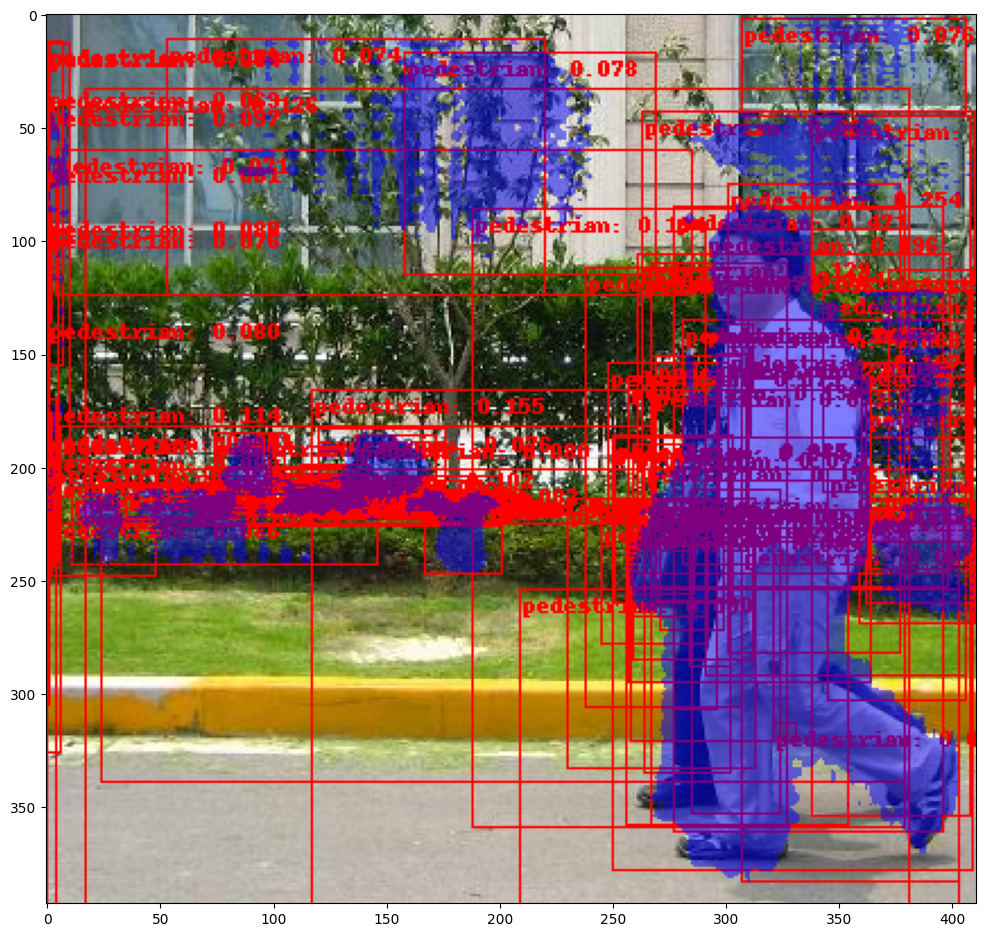

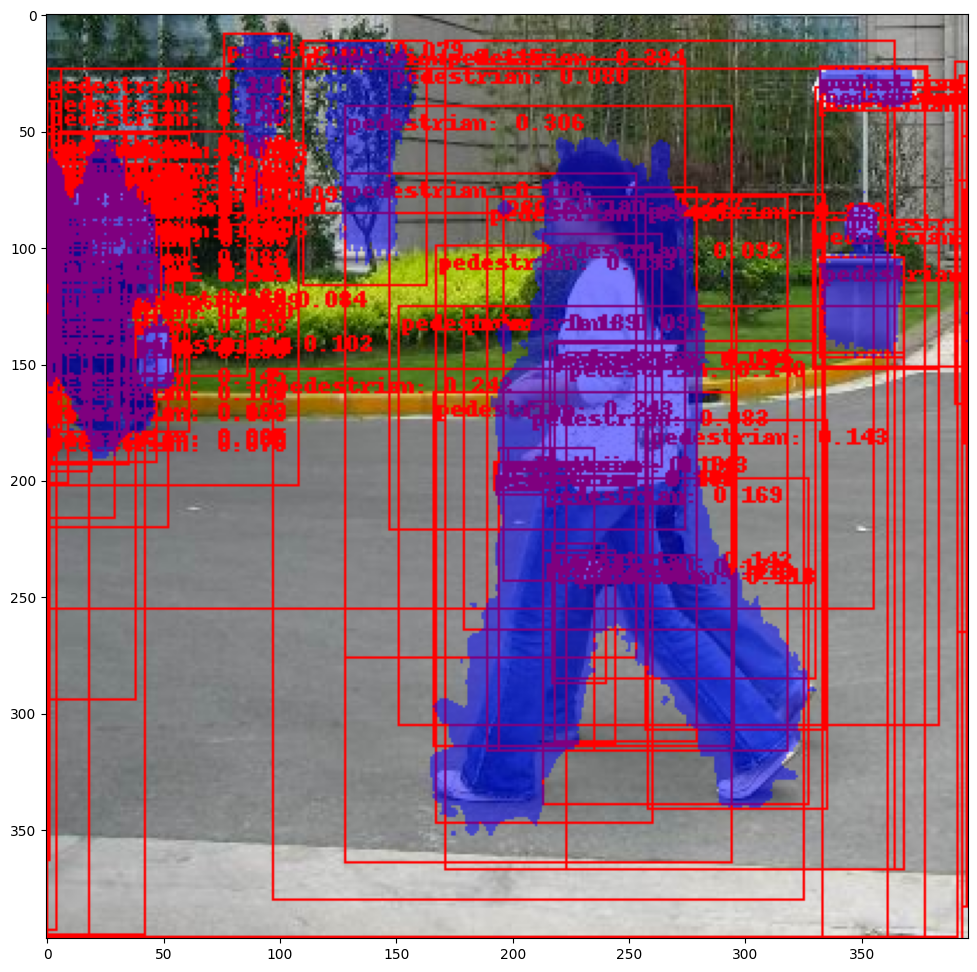

In [21]:
import matplotlib.pyplot as plt
import os
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image_list = os.listdir('datasample')
for image_name in image_list:
  image = read_image('/content/datasample/'+image_name)
  eval_transform = get_transform(train = False)

  model.eval()
  with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device)
    predictions = model([x,])
    pred = predictions[0]

  image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
  image = image[:3, ...]

  pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
  pred_boxes = pred["boxes"].long()
  output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

  masks = (pred["masks"] > 0.7).squeeze(1)
  output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


  plt.figure(figsize=(12, 12))
  plt.imshow(output_image.permute(1, 2, 0))